Saving Segmented_Customers_With_Personas (1).csv to Segmented_Customers_With_Personas (1).csv
✅ Data Loaded
  User_ID Product_ID  Age  Gender      City    Occupation Product_Category  \
0  U10000       P442   56    Male     Rural       Student      Electronics   
1  U10001       P576   46    Male  Suburban    Unemployed      Electronics   
2  U10002       P681   32  Female     Rural    Unemployed       Home Decor   
3  U10003       P971   60    Male     Urban  Professional             Toys   
4  U10004       P322   25    Male  Suburban       Retired         Clothing   

  Weather Time_of_Day Loyalty_Tier  Purchase_Amount  CustomerSegment  \
0   Rainy     Morning       Silver           286.55                1   
1   Rainy     Morning         Gold           249.10                1   
2  Cloudy     Morning       Silver           148.20                2   
3  Cloudy       Night       Bronze            75.71                0   
4   Rainy       Night       Bronze            94.81            

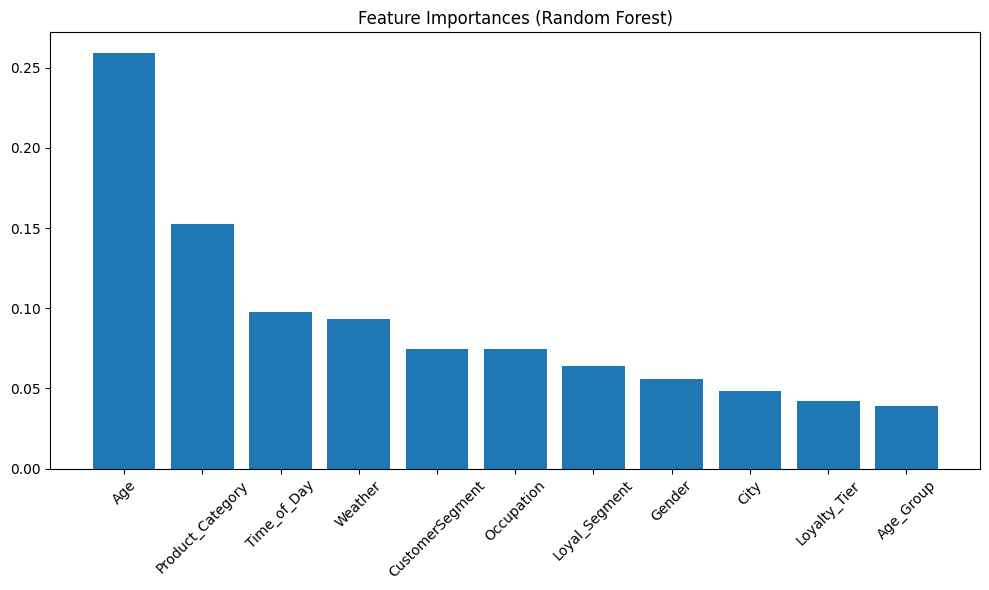

Fitting 3 folds for each of 16 candidates, totalling 48 fits
🔧 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
✅ Tuned Gradient Boosting Evaluation:
🔢 Accuracy: 0.716

📉 Confusion Matrix:
 [[634 278]
 [290 798]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69       912
           1       0.74      0.73      0.74      1088

    accuracy                           0.72      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.72      0.72      0.72      2000

Mounted at /content/drive
✅ Random Forest model saved to: /content/drive/MyDrive/rf_model.pkl
✅ Gradient Boosting model saved to: /content/drive/MyDrive/best_gb_model.pkl


In [ ]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

from google.colab import files

# 📤 Upload and Load Dataset
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

print("✅ Data Loaded")
print(df.head())

# 🎯 Simulate 'Conversion' Target Variable based on Persona
def simulate_conversion(row):
    if row['Persona'] == 'Premium Buyer':
        return np.random.choice([0, 1], p=[0.2, 0.8])
    elif row['Persona'] == 'Impulsive Buyer':
        return np.random.choice([0, 1], p=[0.4, 0.6])
    elif row['Persona'] == 'Bargain Hunter':
        return np.random.choice([0, 1], p=[0.5, 0.5])
    elif row['Persona'] == 'First-Time Buyer':
        return np.random.choice([0, 1], p=[0.7, 0.3])
    elif row['Persona'] == 'Budget Buyer':
        return np.random.choice([0, 1], p=[0.8, 0.2])
    else:
        return np.random.choice([0, 1], p=[0.6, 0.4])


df['Conversion'] = df.apply(simulate_conversion, axis=1)
print("🎯 Conversion Distribution:\n", df['Conversion'].value_counts())

# 🔁 Encode Categorical Variables
data = df.copy()
categorical_cols = ['Gender', 'City', 'Occupation', 'Product_Category',
                    'Weather', 'Time_of_Day', 'Loyalty_Tier']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 🧠 Feature Engineering
def age_group(age):
    if age < 30:
        return 0  # Young
    elif age < 50:
        return 1  # Mid
    else:
        return 2  # Senior

data['Age_Group'] = data['Age'].apply(age_group)

data['Loyal_Segment'] = data['Loyalty_Tier'].astype(str) + "_" + data['CustomerSegment'].astype(str)
data['Loyal_Segment'] = LabelEncoder().fit_transform(data['Loyal_Segment'])

# 🎯 Define Features & Target
features = ['Age', 'Age_Group', 'Gender', 'City', 'Occupation',
            'Product_Category', 'Weather', 'Time_of_Day', 'Loyalty_Tier',
            'CustomerSegment', 'Loyal_Segment']
X = data[features]
y = data['Conversion']

# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
print(f"🧪 Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# ⚖️ Balance with SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("✅ SMOTE applied. Balanced classes.")

# 🌲 Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_sm, y_train_sm)
y_pred_rf = rf_model.predict(X_test)

print("✅ Random Forest Model Evaluation:")
print("🔢 Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_rf))

# 📊 Feature Importance
importances = rf_model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feat_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# 🔧 Gradient Boosting with Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42),
                           param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train_sm, y_train_sm)
best_model = grid_search.best_estimator_

print("🔧 Best Parameters:", grid_search.best_params_)

# 📈 Final Evaluation
y_pred_best = best_model.predict(X_test)

print("✅ Tuned Gradient Boosting Evaluation:")
print("🔢 Accuracy:", round(accuracy_score(y_test, y_pred_best), 4))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_best))

# 💾 Save Models to Google Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install joblib
import joblib

rf_path = '/content/drive/MyDrive/rf_model.pkl'
joblib.dump(rf_model, rf_path)
print(f"✅ Random Forest model saved to: {rf_path}")

gb_path = '/content/drive/MyDrive/best_gb_model.pkl'
joblib.dump(best_model, gb_path)
print(f"✅ Gradient Boosting model saved to: {gb_path}")


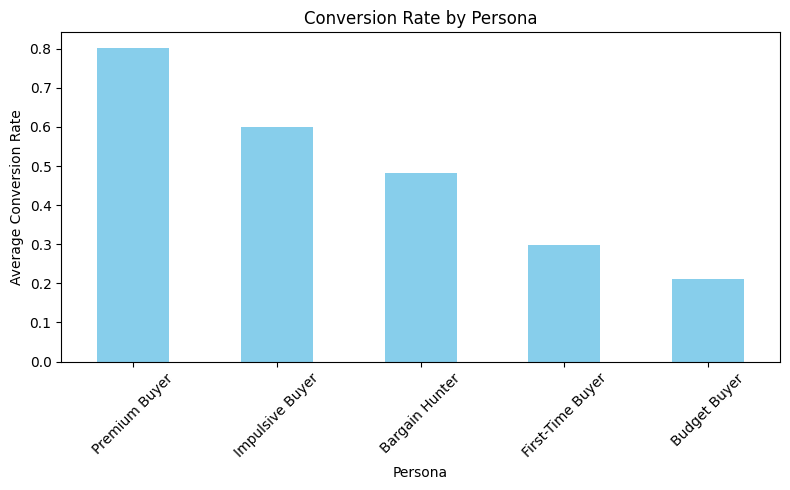

In [ ]:
persona_conversion = df.groupby('Persona')['Conversion'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
persona_conversion.plot(kind='bar', color='skyblue')
plt.title('Conversion Rate by Persona')
plt.ylabel('Average Conversion Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
